# Initialize Libraries

In [179]:
#python helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

#model metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf

#scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV

#data import
from ucimlrepo import fetch_ucirepo 


# Functions

In [180]:
#train test and scale function
def train_test_scale_function(data,technique):
    #train test split
    X=data.drop(columns="quality")
    y=data["quality"] - data["quality"].min()  #need to start at 0 for XG Boost
    X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

    #scaler fitting
    ss=StandardScaler().fit(X_train)
    mm=MinMaxScaler(feature_range=(0,1)).fit(X_train)

    if technique in ["svm","knn","logr","linr","ridge","lasso"]:
        # Standard scaling for SVM, KNN, Logistic Regression, and liner regressions
        X_train_scaled=ss.transform(X_train)
        X_test_scaled=ss.transform(X_test)
    elif technique in ["gb","mbg","nbm","nbg"]:
        #MinMax scaling for gradient boost and naive bayes models
        X_train_scaled=mm.transform(X_train)
        X_test_scaled=mm.transform(X_test)
    else:
        #No scaling for other techniques (e.g., tree based models)
        X_train_scaled=X_train
        X_test_scaled=X_test

    return X_train_scaled, X_test_scaled, y_train, y_test

In [181]:
#classifier function
def classifier_function(data, technique):
    #model mapping
    model_mapping={
        "rf" : RandomForestClassifier,
        "gb" : GradientBoostingClassifier,
        "svm" : SVC,
        "knn" : KNeighborsClassifier,
        "dt" : DecisionTreeClassifier,
        "ert" : ExtraTreesClassifier,
        "ab" : AdaBoostClassifier,
        "xgb" : XGBClassifier,
        "nbg" : GaussianNB,
        "nbm" : MultinomialNB,
        "nbb" : BernoulliNB,
        "logr" : LogisticRegression,
        "linr" : LinearRegression,
        "ridge" : Ridge,
        "lasso" : Lasso
    }

    #data
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(data, technique)

    #commands
    model_class=model_mapping.get(technique)
    if technique in ["rf","gb","dt","ert","ab","logr","ridge","lasso"]:
        model_instance=model_class(random_state=42)
    elif technique=="svm":
        model_instance=model_class(random_state=42,kernel="rbf")
    elif technique in ["knn","xgb","nbg","nbm","nbb","linr"]:
        model_instance=model_class()
    else:
        raise ValueError(f"Unknown model type: {technique}") 
    

    model_instance.fit(X_train_scaled,y_train)
    predictions=model_instance.predict(X_test_scaled)
    
    if technique in ["linr", "ridge", "lasso"]:
        mse=mean_squared_error(y_test,predictions)
        r2=r2_score(y_test,predictions)
        model_train_score=None
        model_test_score=None
    else:
        mse=None
        r2=None
        model_train_score=model_instance.score(X_train_scaled,y_train)
        model_test_score=model_instance.score(X_test_scaled,y_test)
        #classification=classification_report(y_test,predictions)
 
    return model_train_score,model_test_score,mse,r2


In [182]:
#function to produce metrics table
def model_report_function(data):
    # Store classifier results in a dictionary
    classifier_results = {
        "Classifier": ["Random Forest", "Gradient Boost", "SVM", "KNN", "Decision Tree","Extremely Random Tree", "Adaptive Boost", "XG Boost","Naive Bayes Gaussian", "Naive Bayes Multinomial", "Naive Bayes Bernoulli","Logistic Regression"],
        "Training Accuracy": [],
        "Test Accuracy": []
    }

    # Compute accuracy metrics for classifiers
    for model_key in ["rf", "gb", "svm", "knn", "dt", "ert", "ab", "xgb", "nbg", "nbm", "nbb", "logr"]:
        training_acc, test_acc, _, _ = classifier_function(data, model_key)
        classifier_results["Training Accuracy"].append(training_acc)
        classifier_results["Test Accuracy"].append(test_acc)

    # Store regression results in a separate dictionary
    regression_results = {
        "Regressor": ["Linear Regression", "Ridge", "Lasso"],
        "MSE": [], "R Squared": []
    }

    # Compute regression metrics
    for model_key in ["linr", "ridge", "lasso"]:
        _, _, mse, r_squared = classifier_function(data, model_key)
        regression_results["MSE"].append(mse)
        regression_results["R Squared"].append(r_squared)

    # Convert dictionaries to DataFrames and sort
    classifier_df = pd.DataFrame(classifier_results).sort_values("Test Accuracy", ascending=False)
    regression_df = pd.DataFrame(regression_results).sort_values("MSE", ascending=False)

    return classifier_df,regression_df

# Datasets

In [183]:
#Load dataset
wine_data = pd.read_csv('https://archive.ics.uci.edu/static/public/186/data.csv')

display(wine_data.head())
wine_data.info()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [184]:
#encode wine_data color (0 for red, 1 for white)
wine_data_encoded=wine_data.copy()
wine_data_encoded["color"]=np.where(wine_data_encoded["color"]=="red", 0,
                                    np.where(wine_data_encoded["color"]=="white", 1, 100))

#make data subsets
wine_data_red=wine_data[wine_data["color"]=="red"].drop(columns="color")
wine_data_white=wine_data[wine_data["color"]=="white"].drop(columns="color")

#data with less quality classes
wine_data_red_cat=wine_data_red.copy()
wine_data_red_cat["quality"]=np.where(wine_data_red_cat["quality"] <=5, 1,
                                          np.where(wine_data_red_cat["quality"]<=7,2, 3))

wine_data_white_cat=wine_data_white.copy()
wine_data_white_cat["quality"]=np.where(wine_data_white_cat["quality"] <=5, 1,
                                          np.where(wine_data_white_cat["quality"]<=7,2, 3))

wine_data_encoded_cat=wine_data_encoded.copy()
wine_data_encoded_cat["quality"]=np.where(wine_data_encoded_cat["quality"] <=5, 1,
                                          np.where(wine_data_encoded_cat["quality"]<=7,2, 3))

#all colors without level 3
wine_data_encoded_cat_reduced=wine_data_encoded_cat[wine_data_encoded_cat["quality"]!=3]

#all colors and 3 levels iqq filtered
filter_cols=wine_data_encoded_cat.drop(columns=["color","quality","free_sulfur_dioxide","total_sulfur_dioxide","sulphates","residual_sugar","pH"]).columns.tolist()


#IQR filtering
wine_data_encoded_cat_filtered=wine_data_encoded_cat.copy()

wine_data_encoded_cat_filtered=wine_data_encoded_cat_filtered[wine_data_encoded_cat_filtered["quality"]!=3]


for c in filter_cols:
    q1=wine_data_encoded_cat_filtered[c].quantile(0.25)
    q3=wine_data_encoded_cat_filtered[c].quantile(0.75)
    iqr=q3=q1
    lower=q1-1.5*iqr #1.5*iqr seems to have removed too much
    upper=q3+1.5*iqr
    wine_data_encoded_cat_filtered=wine_data_encoded_cat_filtered[(wine_data_encoded_cat_filtered[c]>=lower) & (wine_data_encoded_cat_filtered[c]<=upper)]


wine_data_encoded_cat_filtered

print(wine_data_encoded_cat.shape)
print(wine_data_encoded_cat_filtered.shape)
print(wine_data_encoded_cat_filtered["quality"].unique())


(6497, 13)
(5162, 13)
[2 1]


# Investigate data

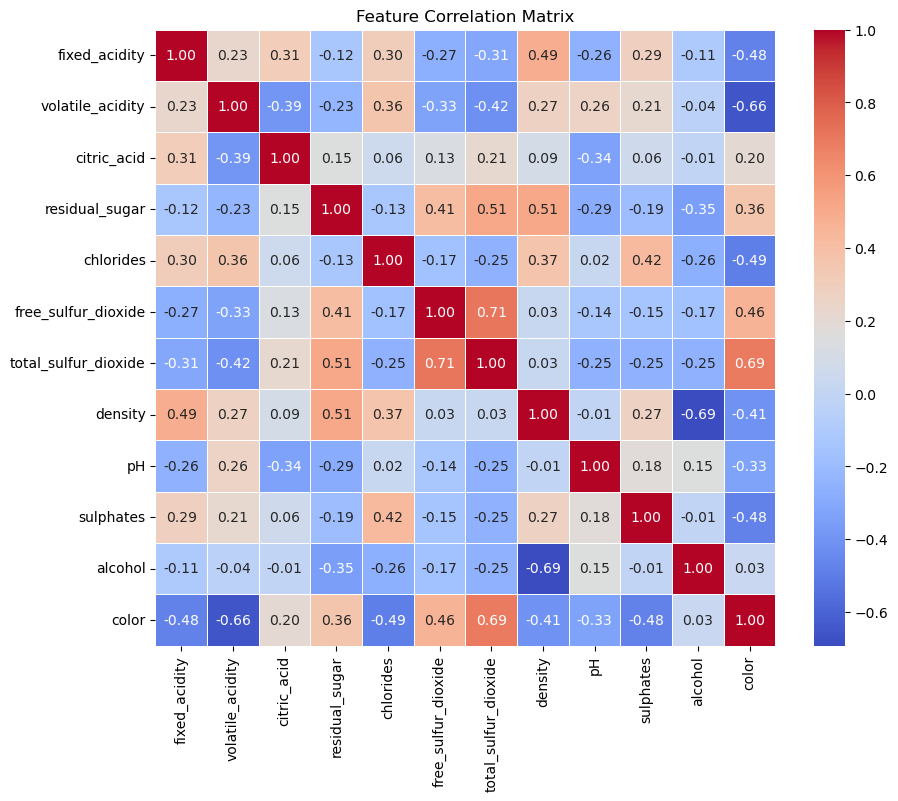

In [185]:
# Assuming `X` is your feature dataset

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


corr_matrix = X_test_scaled.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

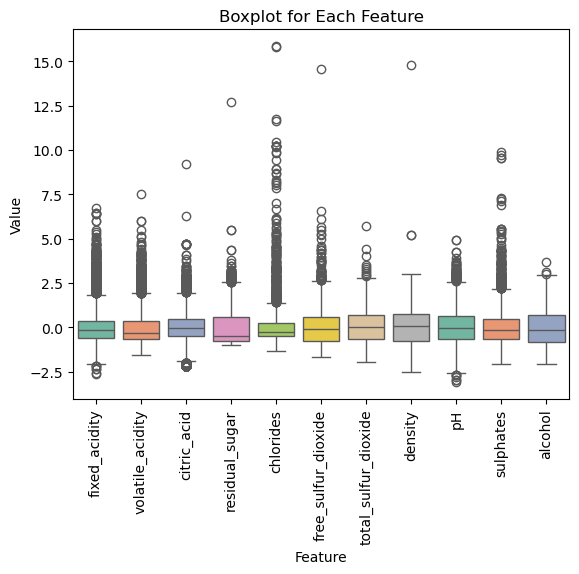

In [187]:
#view the box plot for each feature to look for outliers
#data
features=wine_data.copy()
features=features.drop(columns=["color","quality"])

#initialize scaler to see things on the same y-axis
ss=StandardScaler()
features_scaled=pd.DataFrame(ss.fit_transform(features), columns=features.columns)

#reshape to plot
features_long=features_scaled.melt(var_name="features",value_name="value")

#plot
fig1, ax=plt.subplots()
sns.boxplot(data=features_long, x="features",y="value", palette="Set2")
ax.tick_params(axis="x",rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Value")
ax.set_title("Boxplot for Each Feature")
plt.show()


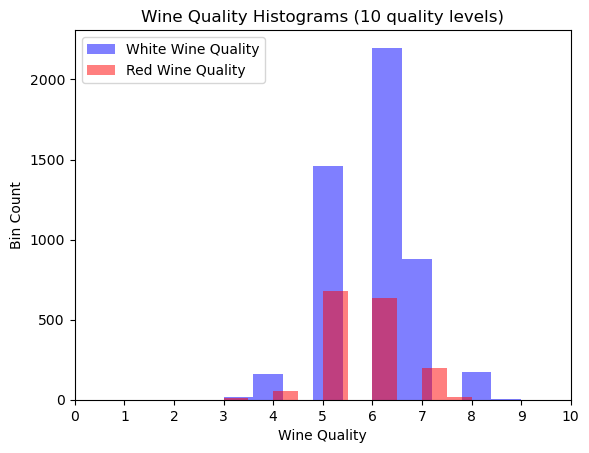

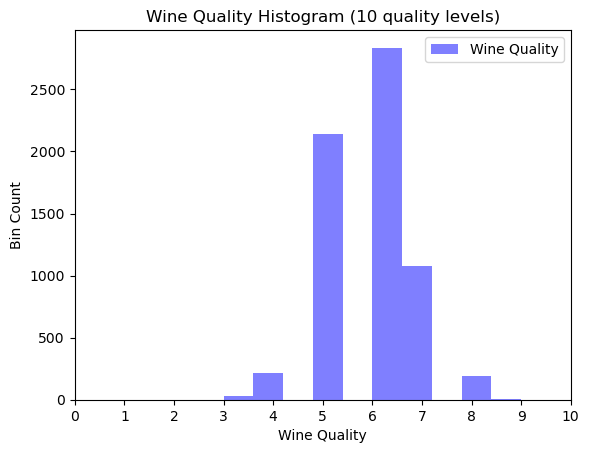

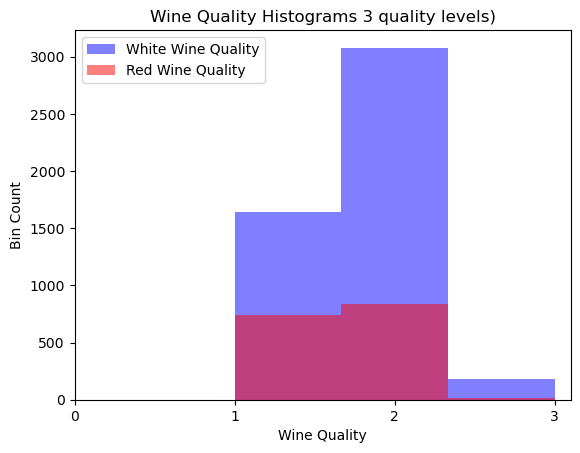

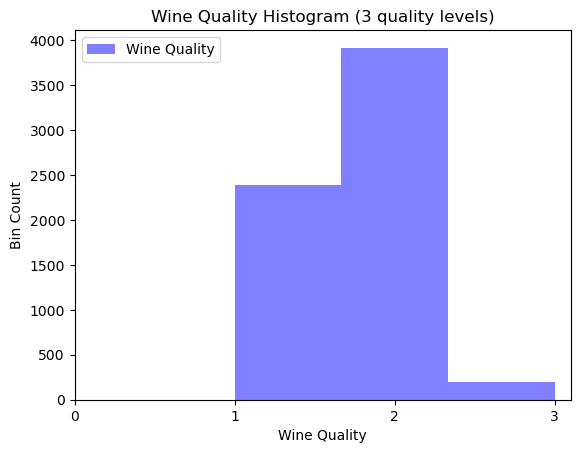

In [188]:
#view the output histograms for each wine color
fig1, ax=plt.subplots()
ax.hist(wine_data_white["quality"],bins=10, alpha=0.5, label="White Wine Quality", color="blue")
ax.hist(wine_data_red["quality"],bins=10, alpha=0.5, label="Red Wine Quality", color="red")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histograms (10 quality levels)")
ax.set_xticks(range(0,11,1))
ax.legend()
plt.show()

#view histogram for wine quality regardless of color
fig2, ax=plt.subplots()
ax.hist(wine_data["quality"],bins=10, alpha=0.5, label="Wine Quality", color="blue")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histogram (10 quality levels)")
ax.set_xticks(range(0,11,1))
ax.legend()
plt.show()


#view histogram for both each color only using 3 quality categories
fig3, ax=plt.subplots()
ax.hist(wine_data_white_cat["quality"],bins=3, alpha=0.5, label="White Wine Quality", color="blue")
ax.hist(wine_data_red_cat["quality"],bins=3, alpha=0.5, label="Red Wine Quality", color="red")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histograms 3 quality levels)")
ax.set_xticks(range(0,4,1))
ax.legend()
plt.show()

#view histogram for wine quality regardless of color with 3 quality levels
#view histogram for wine quality regardless of color
fig4, ax=plt.subplots()
ax.hist(wine_data_encoded_cat["quality"],bins=3, alpha=0.5, label="Wine Quality", color="blue")
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Bin Count")
ax.set_title("Wine Quality Histogram (3 quality levels)")
ax.set_xticks(range(0,4,1))
ax.legend()
plt.show()

In [189]:
#check for nulls and the data types
wine_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 634.6 KB


In [190]:
# Check values
wine_data_encoded.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
fixed_acidity,1.00,0.22,0.32,-0.11,0.30,-0.28,-0.33,0.46,-0.25,0.30,-0.10,-0.08,-0.49
volatile_acidity,0.22,1.00,-0.38,-0.20,0.38,-0.35,-0.41,0.27,0.26,0.23,-0.04,-0.27,-0.65
citric_acid,0.32,-0.38,1.00,0.14,0.04,0.13,0.20,0.10,-0.33,0.06,-0.01,0.09,0.19
residual_sugar,-0.11,-0.20,0.14,1.00,-0.13,0.40,0.50,0.55,-0.27,-0.19,-0.36,-0.04,0.35
chlorides,0.30,0.38,0.04,-0.13,1.00,-0.20,-0.28,0.36,0.04,0.40,-0.26,-0.20,-0.51
free_sulfur_dioxide,-0.28,-0.35,0.13,0.40,-0.20,1.00,0.72,0.03,-0.15,-0.19,-0.18,0.06,0.47
total_sulfur_dioxide,-0.33,-0.41,0.20,0.50,-0.28,0.72,1.00,0.03,-0.24,-0.28,-0.27,-0.04,0.70
density,0.46,0.27,0.10,0.55,0.36,0.03,0.03,1.00,0.01,0.26,-0.69,-0.31,-0.39
pH,-0.25,0.26,-0.33,-0.27,0.04,-0.15,-0.24,0.01,1.00,0.19,0.12,0.02,-0.33
sulphates,0.30,0.23,0.06,-0.19,0.40,-0.19,-0.28,0.26,0.19,1.00,-0.00,0.04,-0.49


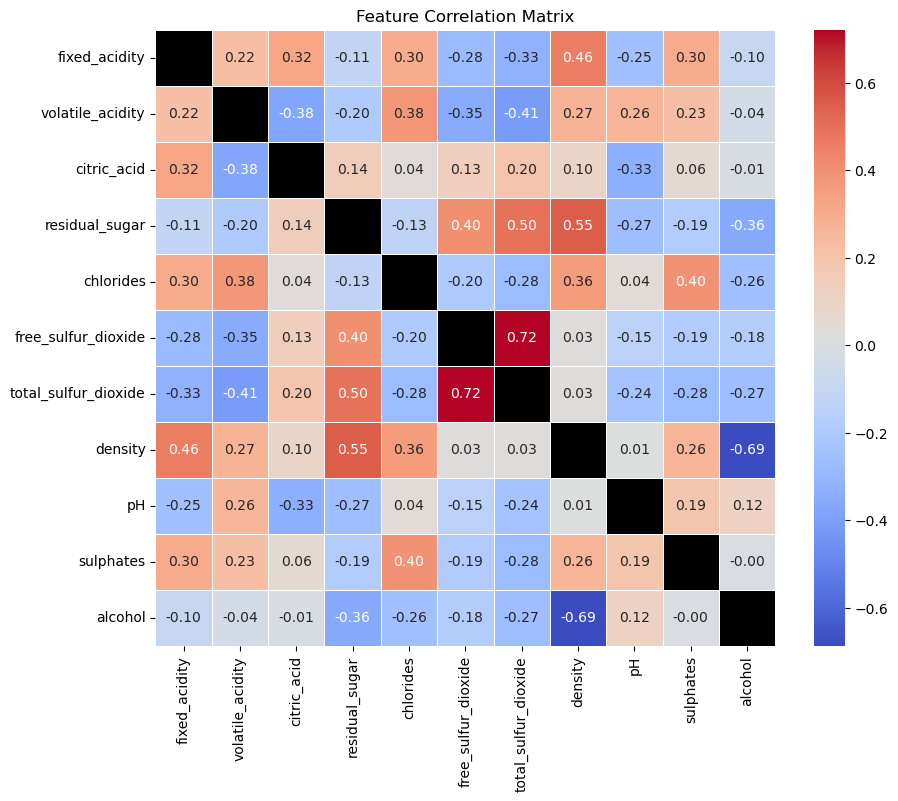

In [201]:
# check for correlations
display(wine_data_encoded.corr().round(2))

data2=wine_data_encoded.drop(columns=["quality","color"])

corr_matrix = data2.corr()
#set the identity digagonal to nan so do get colored
corr_matrix.values[np.diag_indices_from(corr_matrix)] = np.nan

#create custom color map where identity diagonal is black and rest follows cool warm
cmap = sns.color_palette("coolwarm", as_cmap=True)  # Base colormap
cmap.set_bad(color='black')  # Set NaN (bad values) to black

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5,cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()


# Modeling

### Trying various models

In [192]:
#create a loop so can run several datasets on once and plot together

datasets = {
    "All Colors 9 Quality Levels": wine_data_encoded,
    "Red Wine 9 Quality Levels": wine_data_red,
    "White Wine 9 Quality Levels": wine_data_white,
    "All Colors 3 Quality Levels": wine_data_encoded_cat,
    "Red Wine 3 Quality Levels" : wine_data_red_cat,
    "White Wine 3 Quality Levels" : wine_data_white_cat
}

model_comparison=pd.DataFrame()
for dataset_name, dataset in datasets.items():
    data=model_report_function(dataset)[0].round(3)
    data["dataset"]=dataset_name
    model_comparison=pd.concat([model_comparison,data],ignore_index=True)


,Classifier,Training Accuracy,Test Accuracy,dataset,Test Accuracy (%)
0,Random Forest,1.000,0.682,All Colors 9 Quality Levels,68.2
1,Extremely Random Tree,1.000,0.666,All Colors 9 Quality Levels,66.6
2,XG Boost,0.989,0.665,All Colors 9 Quality Levels,66.5
3,Decision Tree,1.000,0.599,All Colors 9 Quality Levels,59.9
4,Gradient Boost,0.707,0.583,All Colors 9 Quality Levels,58.3


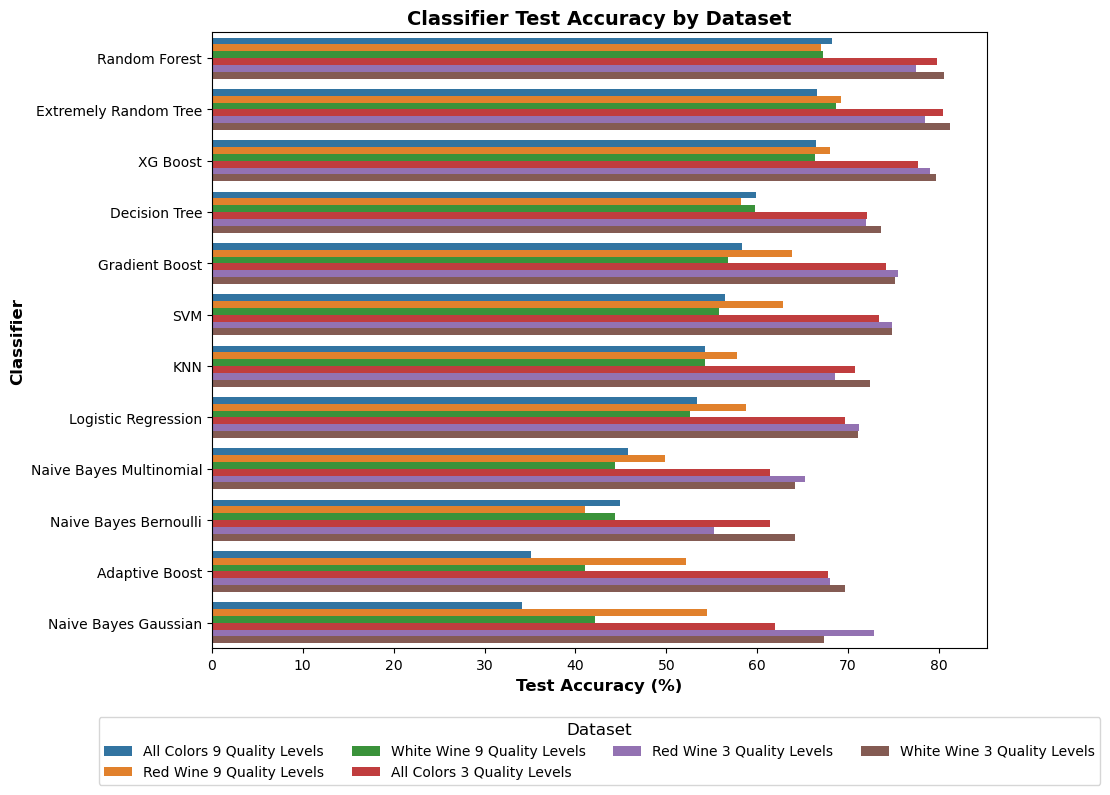

In [193]:
#manipulation of model data
model_comparison2=model_comparison.copy()
model_comparison2["Test Accuracy (%)"]=(model_comparison2["Test Accuracy"]*100).round(1)
display(model_comparison2.head())

#plot
fig5, ax=plt.subplots(figsize=(10,8))
sns.barplot(
    x="Test Accuracy (%)",
    y="Classifier",
    hue="dataset",
    data=model_comparison2,
    orient="h"
)

ax.set_xlabel("Test Accuracy (%)",fontsize=12,fontweight="bold")
ax.set_ylabel("Classifier",fontsize=12,fontweight="bold")
ax.set_title("Classifier Test Accuracy by Dataset", fontsize=14, fontweight="bold")
ax.legend(title="Dataset",fontsize=10,title_fontsize=12,loc="upper center",ncol=4,bbox_to_anchor=(0.5,-0.1))



### In depth Analysis on models

### Extra Random Trees Grid Search

In [194]:
#extremely random trees
#grid search

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

etc = ExtraTreesClassifier(random_state=42)
grid_search = GridSearchCV(estimator=etc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


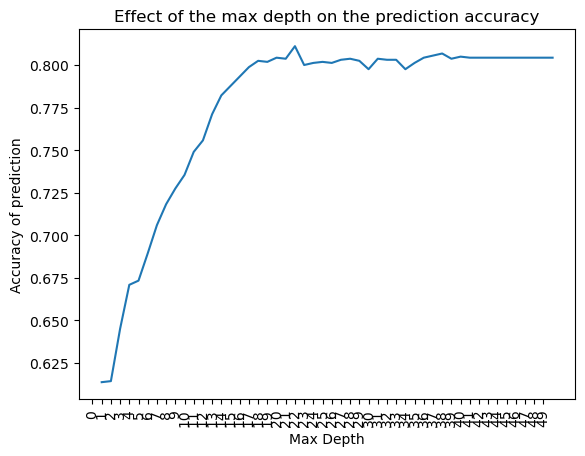

In [81]:
#max depth tuning around 30

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=50
accuracy=[]
for i in range(n):
    ert_model=ExtraTreesClassifier(random_state=42, max_depth=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(1,n+1), accuracy)
plt.xticks(ticks=range(n), rotation=90)
plt.grid=True
plt.xlabel("Max Depth")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the max depth on the prediction accuracy")
plt.show()

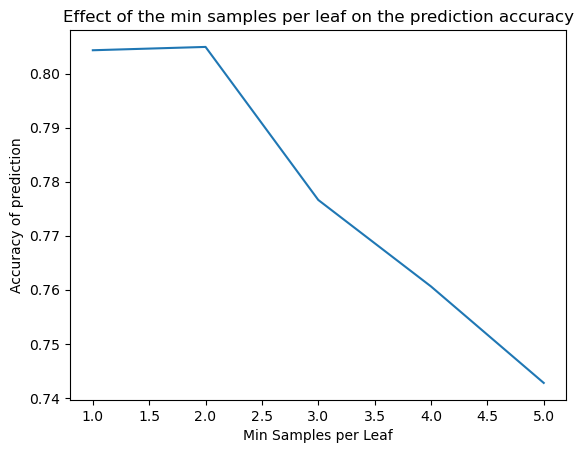

In [82]:
#min_samples_leaf around 1

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=5
accuracy=[]
for i in range(n):
    ert_model=ExtraTreesClassifier(random_state=42, min_samples_leaf=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(1,n+1), accuracy)
plt.xlabel("Min Samples per Leaf")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the min samples per leaf on the prediction accuracy")
plt.show()

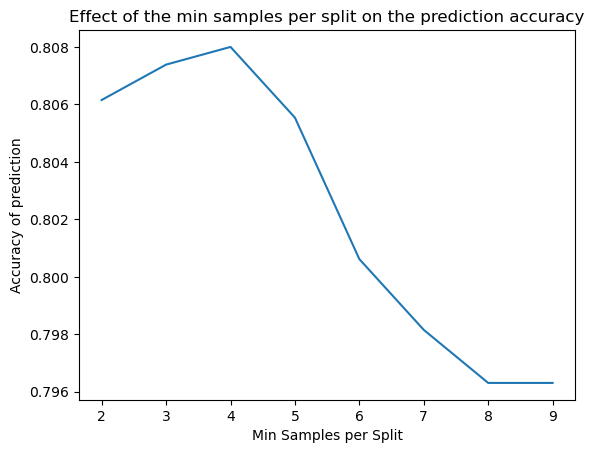

In [83]:
#tuning around min_sample_split

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=10
accuracy=[]
for i in range(2,n,1):
    ert_model=ExtraTreesClassifier(random_state=42, min_samples_split=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(2,n), accuracy)
plt.xlabel("Min Samples per Split")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the min samples per split on the prediction accuracy")
plt.show()

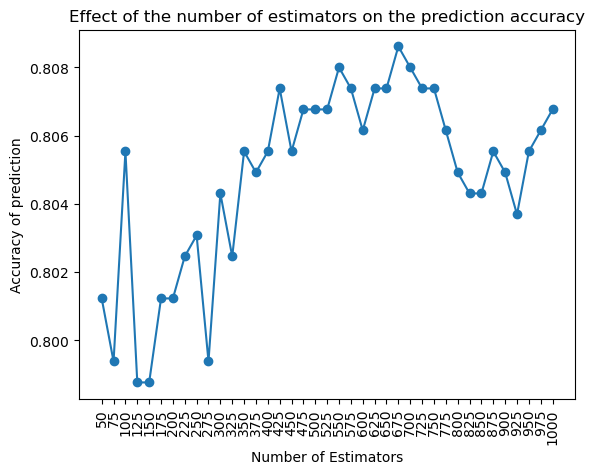

In [85]:
#tuning around n_estimators

X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=1000
accuracy=[]
for i in range(50,n+1,25):
    ert_model=ExtraTreesClassifier(random_state=42, n_estimators=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(50,n+1,25), accuracy, marker="o")
plt.xticks(ticks=range(50,n+1,25), rotation=90)
plt.grid=True
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the number of estimators on the prediction accuracy")
plt.show()

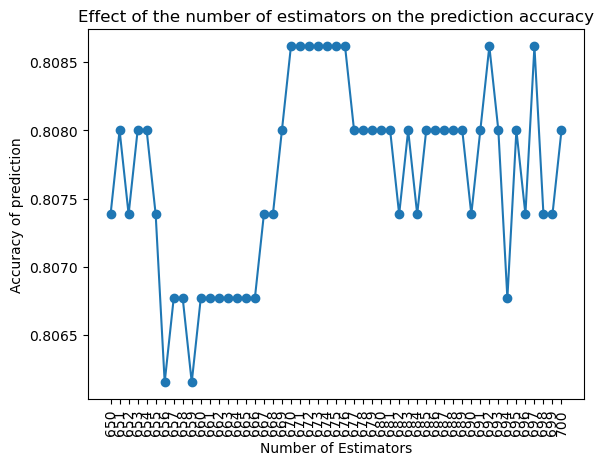

In [86]:
#tune around 675 for n estimators
X_train_scaled, X_test_scaled, y_train, y_test = train_test_scale_function(wine_data_encoded_cat,"ert")


n=700
accuracy=[]
for i in range(650,n+1,1):
    ert_model=ExtraTreesClassifier(random_state=42, n_estimators=i+1)
    ert_model=ert_model.fit(X_train_scaled,y_train)
    predictions=ert_model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test,predictions))

plt.plot(range(650,n+1,1), accuracy, marker="o")
plt.xticks(ticks=range(650,n+1,1), rotation=90)
plt.grid=True
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy of prediction")
plt.title("Effect of the number of estimators on the prediction accuracy")
plt.show()

### Extremely random trees best conditions

In [ ]:
#extremely random trees
#metrics for best parameters

#data
X_train_scaled_best, X_test_scaled_best, y_train_best, y_test_best = train_test_scale_function(wine_data_encoded_cat,"ert")

#initialize model
#ert_model=ExtraTreesClassifier(random_state=42, max_depth=22, max_features="sqrt", min_samples_leaf=2, min_samples_split= 4, n_estimators=675)

ert_model_best=ExtraTreesClassifier(random_state=42, max_depth=30, max_features="sqrt", min_samples_leaf=1, min_samples_split= 5, n_estimators=675)

#fit model
ert_model_best.fit(X_train_scaled_best,y_train_best)

#feature importance
importance_best=ert_model_best.feature_importances_
importance_best_df=pd.DataFrame({
    "Feature" : X_train_scaled_best.columns,
    "Importance" : importance_best}).sort_values(by="Importance", ascending=False)

display(importance_best_df)

#classification report
predictions_best=ert_model_best.predict(X_test_scaled_best)
cr_best=classification_report(y_test_best,predictions_best)
print(cr_best)

#confusion matrix
cm_best=confusion_matrix(y_test_best,predictions_best)
classes=["Class 1","Class 2", "Class 3"]
cm_best_df=pd.DataFrame(cm_best,index=classes,columns=classes)

display(cm_best_df)


,Feature,Importance
10,alcohol,0.183914
1,volatile_acidity,0.119110
7,density,0.085569
5,free_sulfur_dioxide,0.081450
6,total_sulfur_dioxide,0.079770
2,citric_acid,0.079708
9,sulphates,0.077677
3,residual_sugar,0.071088
8,pH,0.070462
4,chlorides,0.070039


              precision    recall  f1-score   support

           0       0.76      0.75      0.75       584
           1       0.83      0.86      0.85       997
           2       1.00      0.30      0.46        44

    accuracy                           0.81      1625
   macro avg       0.86      0.64      0.69      1625
weighted avg       0.81      0.81      0.80      1625



,Class 1,Class 2,Class 3
Class 1,436,148,0
Class 2,136,861,0
Class 3,0,31,13


### feature engineering

### box plots

In [88]:
#function for feature box plots
def feature_boxplots(data,y_data):
    #pairwise comparisons
    pairwise_results = pg.pairwise_ttests(data=data, dv=y_data, between="quality", padjust="bonferroni")

    fig1, ax=plt.subplots(figsize=(8,6))
    sns.boxenplot(data=data, x="quality", y=y_data, palette="viridis")
    box_pairs = [(1, 2),(2,3), (1,3)]
    annotator = Annotator(ax, box_pairs, data=data, x="quality", y=y_data)
    annotator.configure(test="t-test_ind", text_format="star", loc="inside")
    annotator.apply_and_annotate()  
    ax.set_xlabel("Quality")
    ax.set_ylabel(y_data)
    ax.set_title(f"{y_data} vs. Quality Box Plot".title())
    plt.close()

    return fig1, pairwise_results

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:2.797e-224 t=-3.331e+01
2 vs. 3: t-test independent samples, P_val:1.378e-23 t=-1.007e+01
1 vs. 3: t-test independent samples, P_val:1.382e-149 t=-2.786e+01


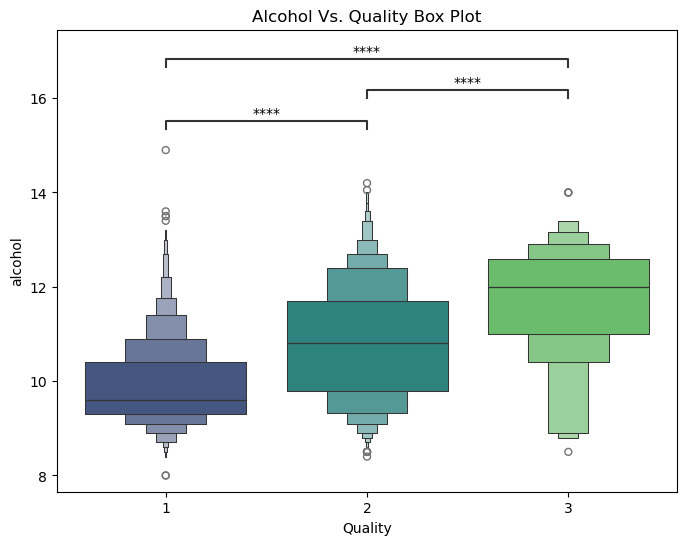

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:1.384e-101 t=2.179e+01
2 vs. 3: t-test independent samples, P_val:1.191e-01 t=1.559e+00
1 vs. 3: t-test independent samples, P_val:7.424e-15 t=7.824e+00


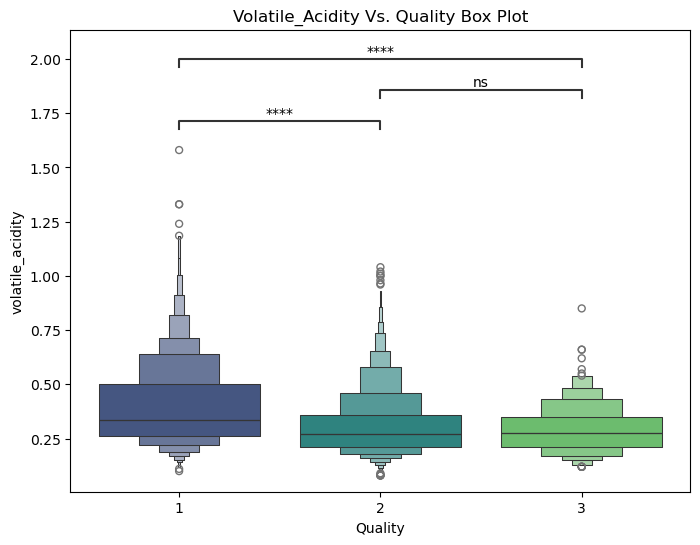

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:1.891e-97 t=2.132e+01
2 vs. 3: t-test independent samples, P_val:1.091e-13 t=7.455e+00
1 vs. 3: t-test independent samples, P_val:3.564e-66 t=1.769e+01


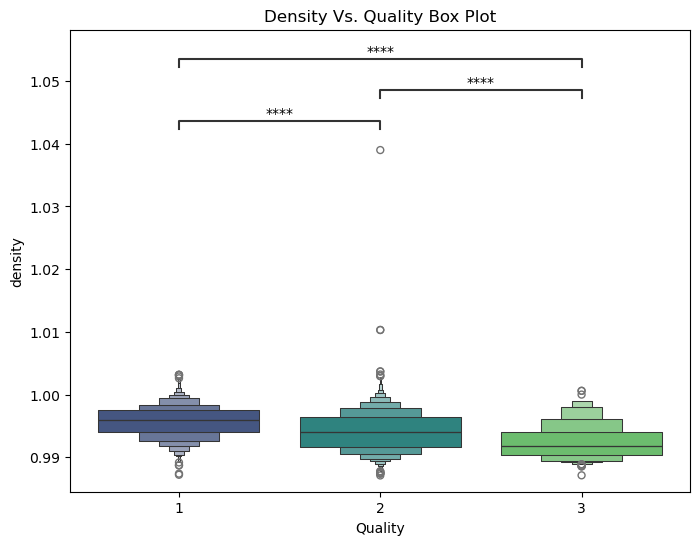

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:1.333e-03 t=-3.210e+00
2 vs. 3: t-test independent samples, P_val:2.968e-03 t=-2.973e+00
1 vs. 3: t-test independent samples, P_val:5.534e-04 t=-3.458e+00


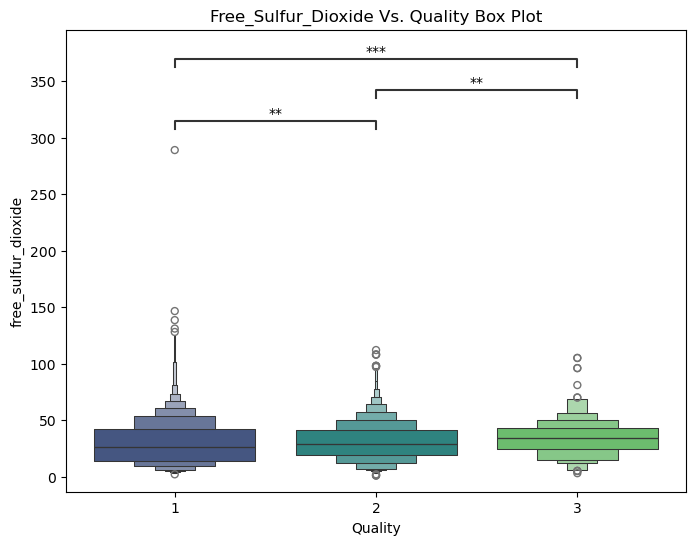

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:9.447e-05 t=3.907e+00
2 vs. 3: t-test independent samples, P_val:3.039e-01 t=-1.028e+00
1 vs. 3: t-test independent samples, P_val:6.884e-01 t=4.011e-01


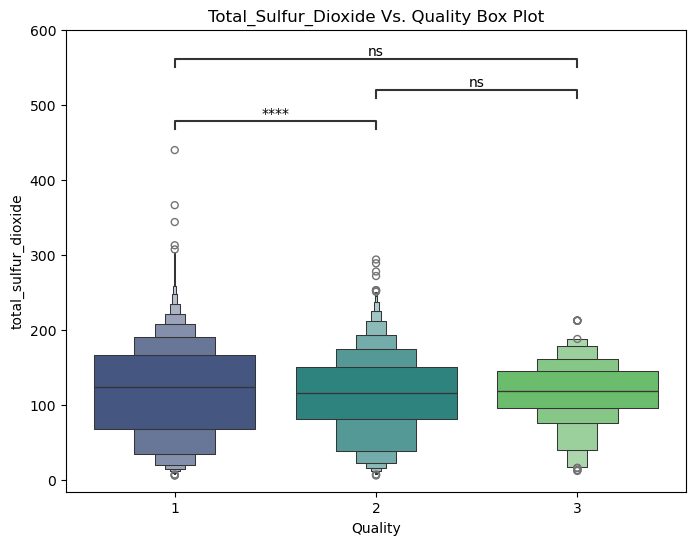

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:3.261e-09 t=-5.926e+00
2 vs. 3: t-test independent samples, P_val:4.571e-01 t=-7.437e-01
1 vs. 3: t-test independent samples, P_val:1.164e-02 t=-2.525e+00


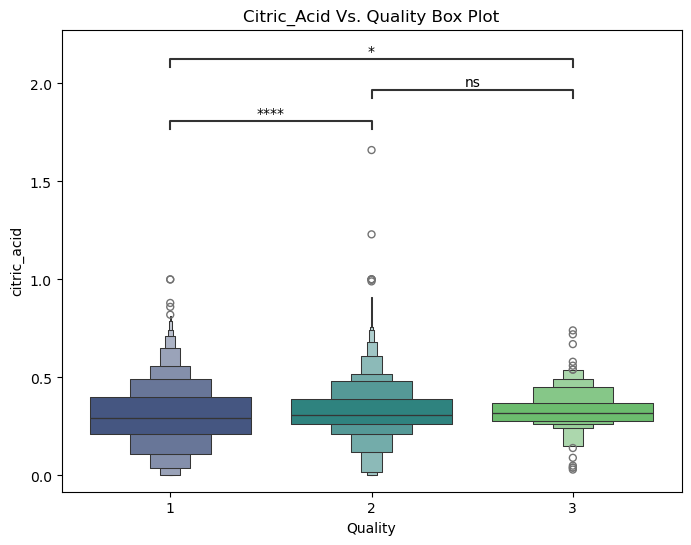

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:1.441e-03 t=-3.188e+00
2 vs. 3: t-test independent samples, P_val:2.226e-02 t=2.287e+00
1 vs. 3: t-test independent samples, P_val:2.285e-01 t=1.204e+00


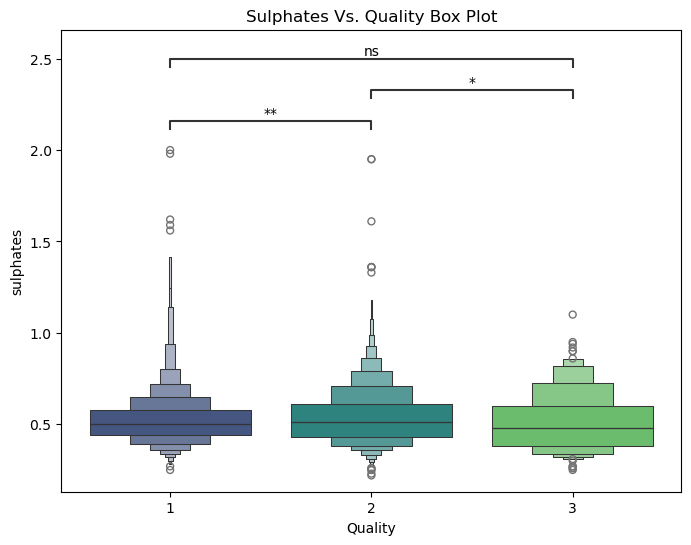

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:9.451e-03 t=2.596e+00
2 vs. 3: t-test independent samples, P_val:9.373e-01 t=-7.871e-02
1 vs. 3: t-test independent samples, P_val:4.119e-01 t=8.207e-01


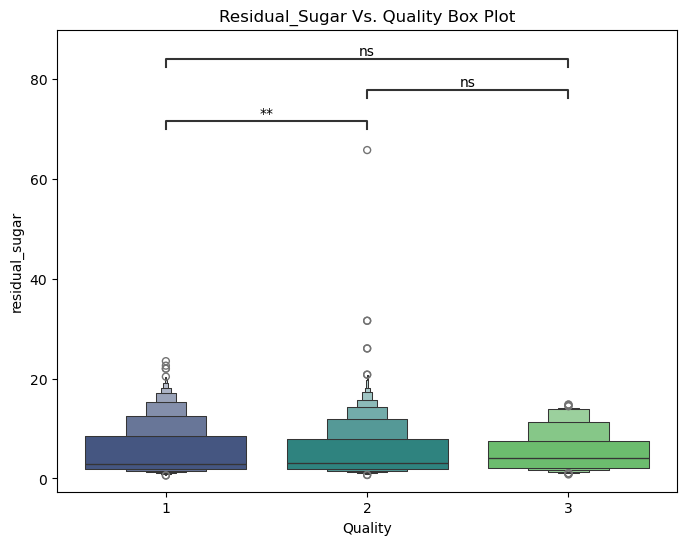

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:1.475e-01 t=-1.449e+00
2 vs. 3: t-test independent samples, P_val:6.829e-01 t=-4.086e-01
1 vs. 3: t-test independent samples, P_val:3.629e-01 t=-9.100e-01


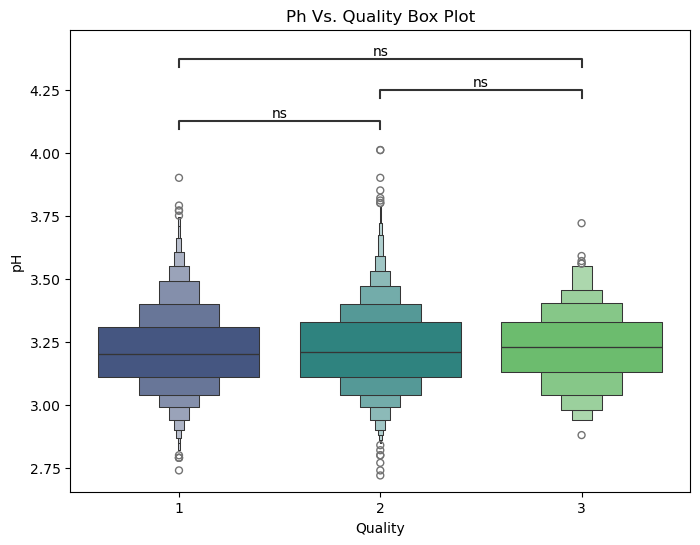

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:4.589e-44 t=1.403e+01
2 vs. 3: t-test independent samples, P_val:1.348e-07 t=5.281e+00
1 vs. 3: t-test independent samples, P_val:1.636e-14 t=7.721e+00


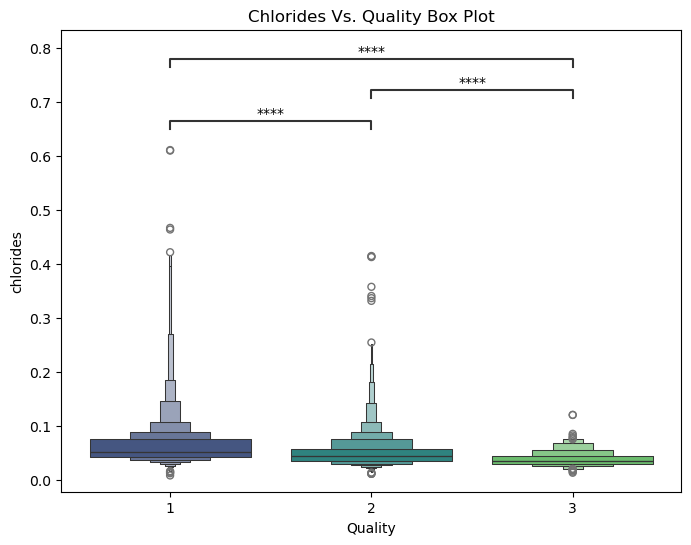

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:8.509e-07 t=4.928e+00
2 vs. 3: t-test independent samples, P_val:9.781e-04 t=3.299e+00
1 vs. 3: t-test independent samples, P_val:2.754e-07 t=5.153e+00


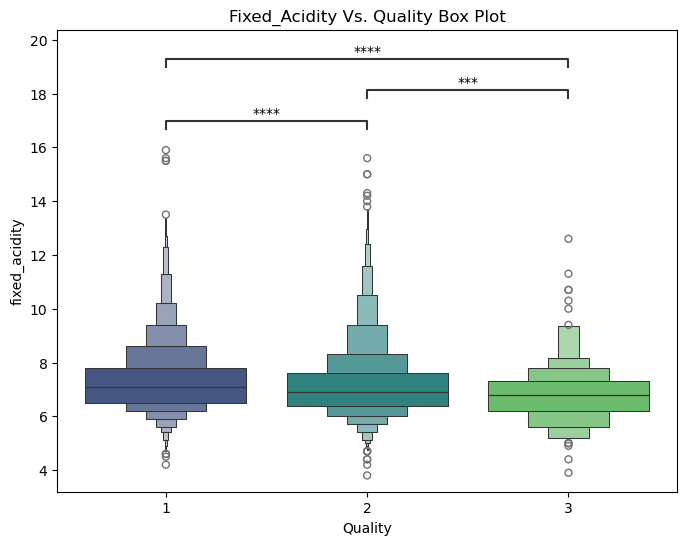

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: t-test independent samples, P_val:2.121e-18 t=-8.778e+00
2 vs. 3: t-test independent samples, P_val:3.176e-05 t=-4.165e+00
1 vs. 3: t-test independent samples, P_val:4.674e-11 t=-6.609e+00


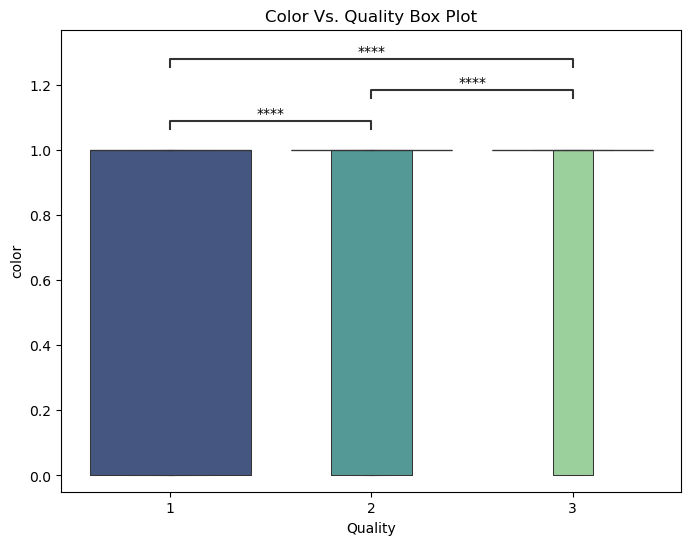

In [89]:
#feature_boxplots(wine_data_encoded_cat)[0]

for j in importance_best_df["Feature"]:
    display(feature_boxplots(wine_data_encoded_cat,j)[0])

In [195]:
#plots to try and investigate features
data=wine_data_encoded_cat.copy()

#pairwise comparisons
pairwise_results = pg.pairwise_ttests(data=data, dv="alcohol", between="quality", padjust="bonferroni")

display(pairwise_results)
display(pairwise_results.columns)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,quality,1,2,False,True,-36.202695,6175.515238,two-sided,1.964918e-260,5.894754e-260,bonferroni,4.058e+256,-0.865358
1,quality,1,3,False,True,-19.734919,211.538019,two-sided,7.356720e-50,2.207016e-49,bonferroni,9.974e+76,-2.060081
2,quality,2,3,False,True,-9.554569,215.108800,two-sided,2.951317e-18,8.853951e-18,bonferroni,1.714e+18,-0.733523


Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

### mis classification exploration

In [306]:
# this is the misclass based on chatgpt
predictions_best_train=ert_model_best.predict(X_train_scaled_best)
predictions_best_test=ert_model.predict(X_test_scaled_best)

y_train_misclass = (predictions_best_train != y_train_best).astype(int)
y_test_misclass = (predictions_best_test != y_test_best).astype(int)

#train and fit a misclass rf model
rf_misclass = RandomForestClassifier(random_state=42)
rf_misclass.fit(X_train_scaled_best, y_train_misclass)

#i think this similar to what what done before.  All the optimization and feature engineering of the mis class model did not seem to help.  So going straight to probs
misclass_probs_test = rf_misclass.predict_proba(X_test_scaled_best)[:, 1]
misclass_probs_train = rf_misclass.predict_proba(X_train_scaled_best)[:, 1]

#use standard scaler on probs
ss=StandardScaler()
misclass_probs_train_scaled = ss.fit_transform(misclass_probs_train.reshape(-1, 1))
misclass_probs_test_scaled = ss.transform(misclass_probs_test.reshape(-1, 1))

#add these probs as a feature to X and Y data used to train the original extra tree model that was optimized with grid search
X_train_scaled_best_probs=X_train_scaled_best.copy()
X_train_scaled_best_probs=np.column_stack((X_train_scaled_best, misclass_probs_train_scaled))

X_test_scaled_best_probs=X_test_scaled_best.copy()
X_test_scaled_best_probs=np.column_stack((X_test_scaled_best, misclass_probs_test_scaled))


#retrain model on data with probs as feature
ert_model_best_probs=ExtraTreesClassifier(random_state=42, max_depth=30, max_features="sqrt", min_samples_leaf=1, min_samples_split= 5, n_estimators=675)
ert_model_best_probs.fit(X_train_scaled_best_probs,y_train_best)
#predicionts
ert_model_best_probs_pred=ert_model_best_probs.predict(X_test_scaled_best_probs)

#get metrics
print(classification_report(y_test_best,ert_model_best_probs_pred))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75       584
           1       0.83      0.86      0.84       997
           2       1.00      0.30      0.46        44

    accuracy                           0.80      1625
   macro avg       0.86      0.63      0.68      1625
weighted avg       0.81      0.80      0.80      1625



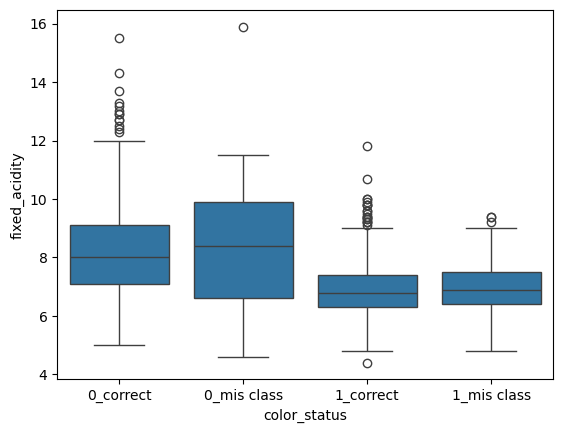

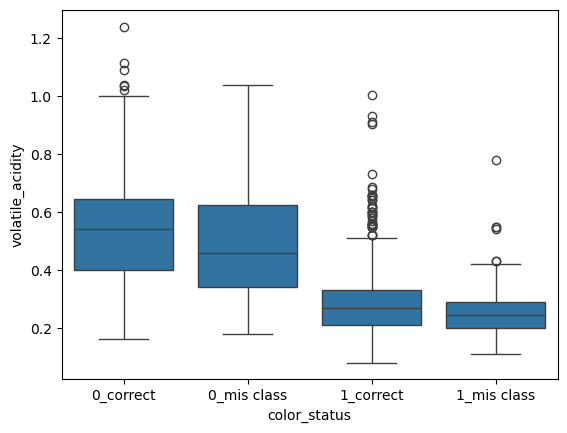

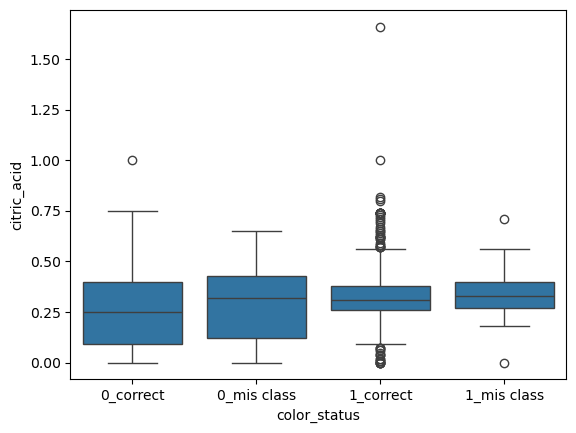

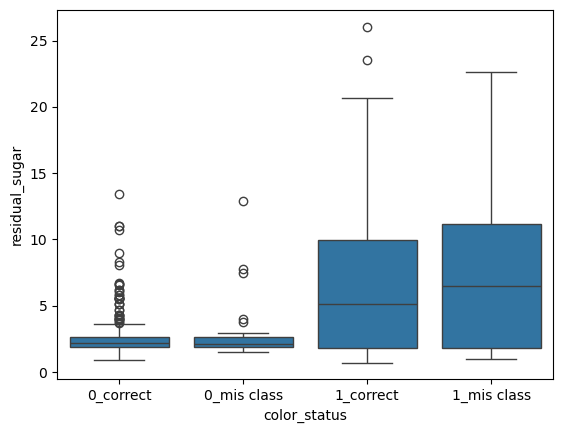

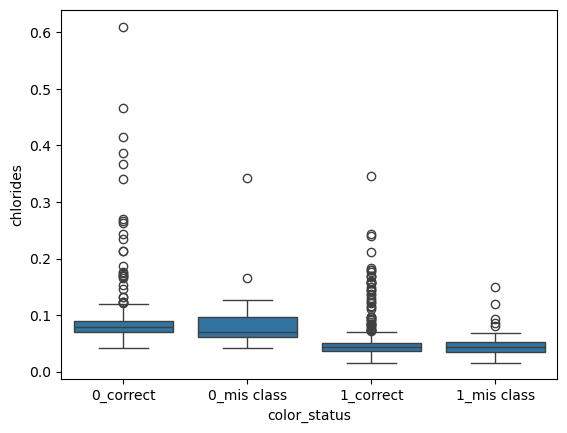

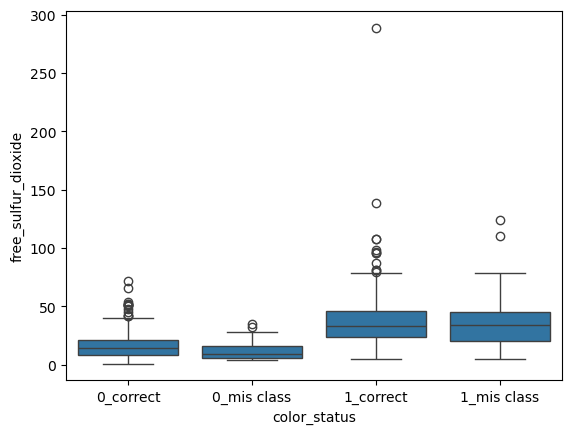

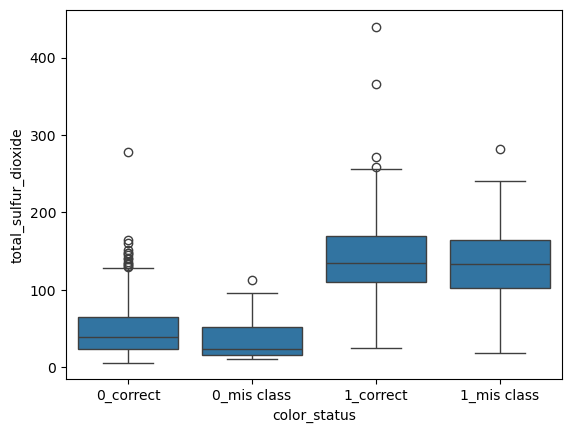

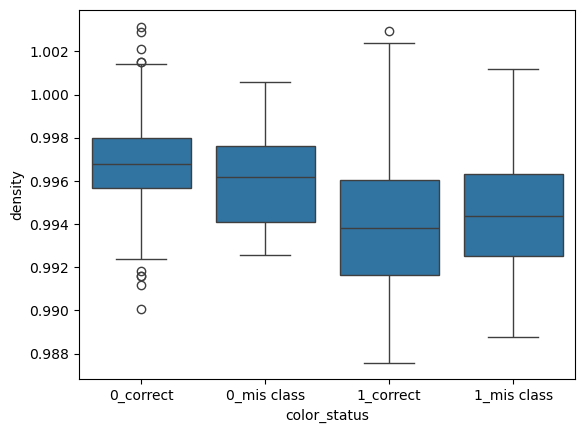

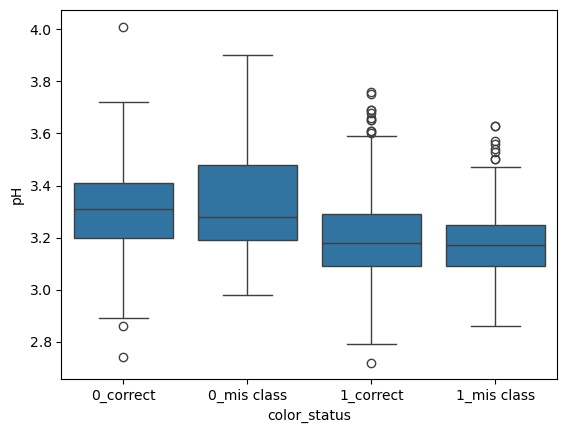

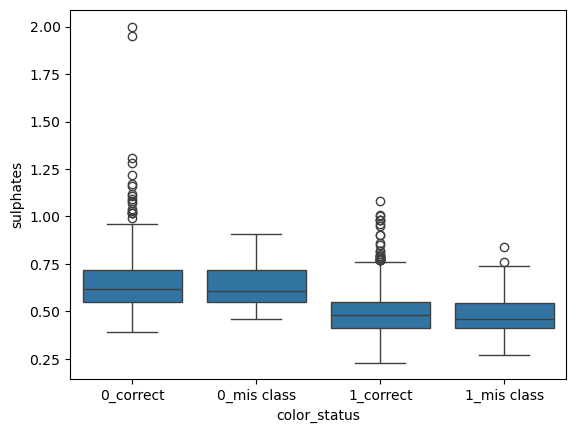

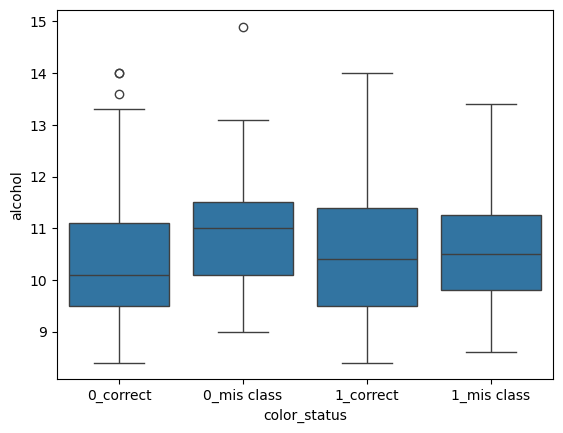

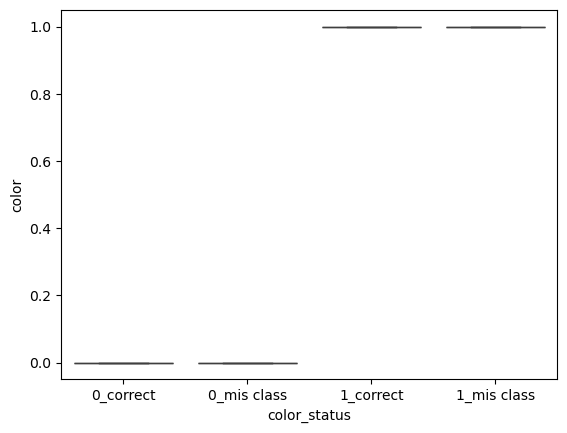

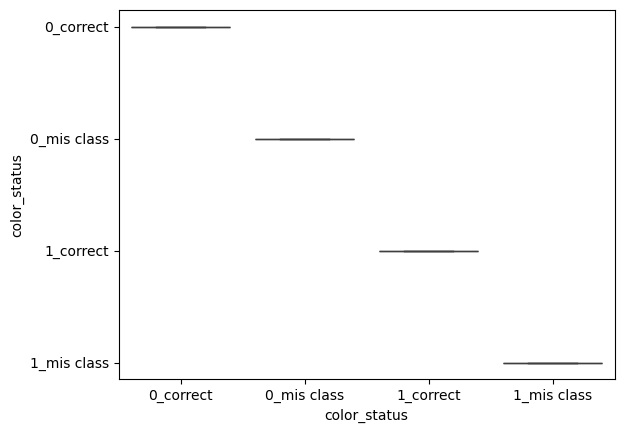

In [ ]:
#this is the misclass that I did
#exploring class 1 and class 2 mis-classification in random tree
predictions_best
#type(y_test_best)

mis_class_1_2=pd.DataFrame(y_test_best).copy()
mis_class_1_2["prediction"]=predictions_best
mis_class_1_2=mis_class_1_2[(mis_class_1_2["quality"]==0) & (mis_class_1_2["prediction"]==1)]
mis_class_1_2

df=X_test_scaled_best.copy()
df["status"]=df.index.isin(mis_class_1_2.index)
df["status"]=df["status"].replace({True : "mis class", False : "correct"})
df["quality"]=1
df["color_status"]=df["color"].astype("str") + "_" + df["status"]
df=df.sort_values("color_status")


#box plots for features
features=df.drop(columns=["quality","status"])

for f in features:
    fig6, ax=plt.subplots()
    sns.boxplot(data=df,
                    x="color_status",
                    y=f)



In [ ]:
# trying knn on misclass dataset to see if the misclassified ones occupy a space
#encode status column (0=correct, 1=mis class)
df_encode=df.copy()
df_encode["status"]=df_encode["status"].replace({"correct" : 0, "mis class" : 1})

#make X and y
X=df_encode.drop(columns=["status","quality","color_status"])
y=df_encode["status"]

#splt data
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

#initialize model
knn_model=KNeighborsClassifier()

#fit model
knn_model.fit(X_train, y_train)

#predictions
knn_predictions=knn_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test,knn_predictions))
print("-"*150)
print("Accuracy Score:\n", accuracy_score(y_test,knn_predictions))
print("-"*150)
print("Classification Report\n", classification_report(y_test,knn_predictions))




Confusion Matrix:
 [[364   1]
 [ 42   0]]
------------------------------------------------------------------------------------------------------------------------------------------------------
Accuracy Score:
 0.8943488943488943
------------------------------------------------------------------------------------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.90      1.00      0.94       365
           1       0.00      0.00      0.00        42

    accuracy                           0.89       407
   macro avg       0.45      0.50      0.47       407
weighted avg       0.80      0.89      0.85       407



In [223]:
# trying random forest to see if get better results

#initialize model
rf_model=RandomForestClassifier()

#fit model
rf_model.fit(X_train, y_train)

#predictions
rf_predictions=rf_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test,rf_predictions))
print("-"*150)
print("Accuracy Score:\n", accuracy_score(y_test,rf_predictions))
print("-"*150)
print("Classification Report\n", classification_report(y_test,rf_predictions))


Confusion Matrix:
 [[365   0]
 [ 41   1]]
------------------------------------------------------------------------------------------------------------------------------------------------------
Accuracy Score:
 0.8992628992628993
------------------------------------------------------------------------------------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       365
           1       1.00      0.02      0.05        42

    accuracy                           0.90       407
   macro avg       0.95      0.51      0.50       407
weighted avg       0.91      0.90      0.85       407



In [269]:
#applying SMOT to mis classified (1) samples to try and boost sample for the models since KNN and random forest are basically ignoring that class

from imblearn.over_sampling import SMOTE
#use the same same X and Y as KNN and Random Forest

smote=SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)

#re-doing random forest with the resampling
#initialize model
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

#fit rf_model
rf_model.fit(X_train, y_train)

#predictions
rf_predictions=rf_model.predict(X_test)

#feature importance
feature_importances = rf_model.feature_importances_
fi_df=pd.DataFrame({"Feature":X_train.columns,"Importance":feature_importances})

fi_df=fi_df.sort_values(by="Importance", ascending=False)

print(classification_report(y_test,rf_predictions))
print("-"*150)
print(fi_df)



              precision    recall  f1-score   support

           0       0.93      0.90      0.91       371
           1       0.90      0.93      0.92       368

    accuracy                           0.91       739
   macro avg       0.92      0.91      0.91       739
weighted avg       0.92      0.91      0.91       739

------------------------------------------------------------------------------------------------------------------------------------------------------
                 Feature  Importance
10               alcohol    0.136254
6   total_sulfur_dioxide    0.107887
1       volatile_acidity    0.098971
7                density    0.098000
2            citric_acid    0.095339
5    free_sulfur_dioxide    0.088005
3         residual_sugar    0.080622
9              sulphates    0.076891
8                     pH    0.076869
0          fixed_acidity    0.067883
4              chlorides    0.066059
11                 color    0.007221


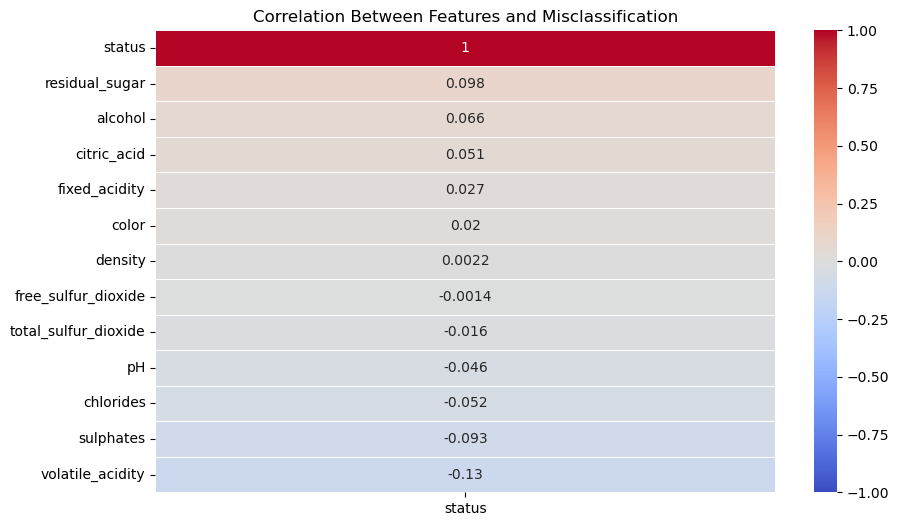

status                  1.000000
residual_sugar          0.098003
alcohol                 0.065818
citric_acid             0.050854
fixed_acidity           0.027393
color                   0.020288
density                 0.002168
free_sulfur_dioxide    -0.001445
total_sulfur_dioxide   -0.016295
pH                     -0.046258
chlorides              -0.052438
sulphates              -0.092951
volatile_acidity       -0.128929
Name: status, dtype: float64

In [261]:
#look at the correlation plot for mis classified dataset
#add status to X_train
X_train_status=X_train.copy()
X_train_status["status"]=y_train  #note: 0=correct, 1=mis class

#make correlation matrix
corr = X_train_status.corr()

#plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr[["status"]].sort_values(by="status", ascending=False), 
            annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Between Features and Misclassification")
plt.show()

corr["status"].sort_values(ascending=False)

In [264]:
#make some new features
X_train2 = X_train.copy()
X_test2 = X_test.copy() 

X_train2["acidity_sulphates_ratio"] = X_train2["volatile_acidity"] / (X_train2["sulphates"] + 1e-6)

X_train2["sugar_acidity_interaction"] = X_train2["residual_sugar"] * X_train2["volatile_acidity"]

X_train2["sulphates_squared"] = X_train2["sulphates"] ** 2  # 
#To capture nonlinear effects

X_test2["acidity_sulphates_ratio"] = X_test2["volatile_acidity"] / (X_test2["sulphates"] + 1e-6)

X_test2["sugar_acidity_interaction"] = X_test2["residual_sugar"] * X_test2["volatile_acidity"]

X_test2["sulphates_squared"] = X_test2["sulphates"] ** 2  # To capture nonlinear effects



#train another rf model
rf_model2_features=RandomForestClassifier(random_state=42)
#fit
rf_model2_features.fit(X_train2, y_train)
#predict
rf_pred2=rf_model2_features.predict(X_test2)
#get metrics
feature_importances2= rf_model2_features.feature_importances_
fi_df2=pd.DataFrame({"Feature":X_train2.columns,"Importance":feature_importances2})

fi_df2=fi_df2.sort_values(by="Importance", ascending=False)

print(classification_report(y_test,rf_pred2))
print("-"*150)
print(fi_df2)


              precision    recall  f1-score   support

           0       0.92      0.89      0.91       371
           1       0.90      0.92      0.91       368

    accuracy                           0.91       739
   macro avg       0.91      0.91      0.91       739
weighted avg       0.91      0.91      0.91       739

------------------------------------------------------------------------------------------------------------------------------------------------------
                      Feature  Importance
10                    alcohol    0.125506
6        total_sulfur_dioxide    0.083530
7                     density    0.082779
2                 citric_acid    0.079597
5         free_sulfur_dioxide    0.075605
1            volatile_acidity    0.073845
3              residual_sugar    0.067963
12    acidity_sulphates_ratio    0.064262
8                          pH    0.064081
0               fixed_acidity    0.057781
14          sulphates_squared    0.056535
9                 

In [265]:
#trying some other features
X_train3 = X_train.copy()
X_test3 = X_test.copy() 

X_train3["so2_ratio"] = X_train3["free_sulfur_dioxide"] / (X_train3["total_sulfur_dioxide"] + 1e-6)

X_train3["alcohol_density"] = X_train3["alcohol"] * X_train3["density"]

X_train3["sugar_acidity_balance"] = X_train3["residual_sugar"] / (X_train3["fixed_acidity"] + 1e-6)

X_test3["so2_ratio"] = X_test3["free_sulfur_dioxide"] / (X_test3["total_sulfur_dioxide"] + 1e-6)

X_test3["alcohol_density"] = X_test3["alcohol"] * X_test3["density"]

X_test3["sugar_acidity_balance"] = X_test3["residual_sugar"] / (X_test3["fixed_acidity"] + 1e-6)


#train another rf model
rf_model3_features=RandomForestClassifier(random_state=42)
#fit
rf_model3_features.fit(X_train3, y_train)
#predict
rf_pred3=rf_model3_features.predict(X_test3)
#get metrics
feature_importances3= rf_model3_features.feature_importances_
fi_df3=pd.DataFrame({"Feature":X_train3.columns,"Importance":feature_importances2})

fi_df3=fi_df3.sort_values(by="Importance", ascending=False)

print(classification_report(y_test,rf_pred3))
print("-"*150)
print(fi_df3)


              precision    recall  f1-score   support

           0       0.92      0.90      0.91       371
           1       0.90      0.92      0.91       368

    accuracy                           0.91       739
   macro avg       0.91      0.91      0.91       739
weighted avg       0.91      0.91      0.91       739

------------------------------------------------------------------------------------------------------------------------------------------------------
                  Feature  Importance
10                alcohol    0.125506
6    total_sulfur_dioxide    0.083530
7                 density    0.082779
2             citric_acid    0.079597
5     free_sulfur_dioxide    0.075605
1        volatile_acidity    0.073845
3          residual_sugar    0.067963
12              so2_ratio    0.064262
8                      pH    0.064081
0           fixed_acidity    0.057781
14  sugar_acidity_balance    0.056535
9               sulphates    0.054917
4               chlorides   

In [267]:
#feature engineering is not helping much.  Lets hyper tune the and get what we can
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [268]:
#fit with best parmameters
# Get best parameters
best_params = grid_search.best_params_

# Train Random Forest with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on test set
y_pred = best_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report
print("Classification Report (After Hyperparameter Tuning):\n")
print(classification_report(y_test, y_pred))

Classification Report (After Hyperparameter Tuning):

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       371
           1       0.90      0.93      0.91       368

    accuracy                           0.91       739
   macro avg       0.91      0.91      0.91       739
weighted avg       0.91      0.91      0.91       739



In [ ]:
#Add Misclassification Probability as a Meta-Feature

#redoing X and y
#make X and y
X=df_encode.drop(columns=["status","quality","color_status"])
y=df_encode["status"]

#rf_model was defined in SMOT block.  Use this since feature engineering on that model did not help

rf_model_probs=rf_model.predict_proba(X)[:,1]

X_new=X.copy()
X_new['misclass_prob'] =rf_model_probs

#retune with probs as feature


#get metrics



,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color,misclass_prob
584,11.8,0.33,0.49,3.4,0.093,54.0,80.0,1.00020,3.30,0.76,10.7,0,0.09
604,8.3,0.58,0.13,2.9,0.096,14.0,63.0,0.99840,3.17,0.62,9.1,0,0.00
655,9.7,0.55,0.17,2.9,0.087,20.0,53.0,1.00040,3.14,0.61,9.4,0,0.03
101,7.8,0.50,0.30,1.9,0.075,8.0,22.0,0.99590,3.31,0.56,10.4,0,0.11
1575,7.5,0.52,0.40,2.2,0.060,12.0,20.0,0.99474,3.26,0.64,11.8,0,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,6.9,0.18,0.33,1.0,0.054,24.0,164.0,0.99260,3.42,0.51,10.5,1,0.87
3758,6.3,0.24,0.37,1.8,0.031,6.0,61.0,0.98970,3.30,0.34,12.2,1,0.87
5988,6.3,0.28,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,1,0.92
3166,7.5,0.19,0.49,1.8,0.055,19.0,110.0,0.99460,3.33,0.44,9.9,1,0.34
